# Homework 4
---

Released on Nov 26 -- due by *Dec 3, 11:59pm*.

In this homework assignment we will develop a copy number caller based on a Hidden Markov Model. In addition, we will implement a hierarchical clustering algorithm. The data that we consider is from a previously published [breast tumor](http://dx.doi.org/10.1038/nature09807), from which 100 single cells have been sequenced. In this homework assignment we restrict our attention to a subset of 25 cells.

_Instructions:_ There are four questions, worth a total of 100 points. In addition, there are two bonus questions (Q2e and Q4c), each worth 5 points. Insert your answer after each question in the designated box. Replace comments with code.

Hand in your work by emailing the Jupyter notebook (please rename as "LASTNAME_FIRSTNAME.ipynb") to Anusri and myself.

---

## Question 1: Data preparation [20 points]

We start by parsing the data from `data.tsv` using pandas.

In [2]:
from __future__ import print_function
%matplotlib inline
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:
df = pd.read_csv("data.tsv", sep="\t", index_col=0)
df.head()

,CHR,START,END,SRR089377,SRR054598,SRR053605,SRR054594,SRR089397,SRR054614,SRR089402,...,SRR054606,SRR054613,SRR053631,SRR054575,SRR053679,SRR054604,SRR053611,SRR053607,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
0,chr1,1,1246396,2116,298,573,157,3146,1495,4071,...,854,1583,1106,1847,795,562,1211,636,751,1520
1,chr1,1246395,1833664,1940,264,660,204,1643,1207,3809,...,651,848,1252,2024,830,584,836,475,673,1185
2,chr1,1833663,2345598,1767,261,870,237,1655,1621,5418,...,707,1372,1342,2531,1153,874,936,630,818,1366
3,chr1,2345597,2946628,2246,446,854,265,1564,1838,5625,...,1227,1172,1578,2909,1373,884,1184,604,973,1701
4,chr1,2946627,3452945,2189,363,883,217,2081,1173,4845,...,687,1371,1562,3235,1053,854,785,649,784,1212


This dataset consists of the following 25 cells:

In [4]:
cells = list(df.columns[3:])
sys.stdout.write("Cells:")
for idx, cell in enumerate(cells):
    if idx % 5 == 0:
        sys.stdout.write("\n")
    sys.stdout.write(cell + " ")

Cells:
SRR089377 SRR054598 SRR053605 SRR054594 SRR089397 
SRR054614 SRR089402 SRR053676 SRR053633 SRR053617 
SRR054608 SRR053608 SRR054602 SRR089401 SRR053668 
SRR054606 SRR054613 SRR053631 SRR054575 SRR053679 
SRR054604 SRR053611 SRR053607 SRR053602 SRR054610 

The reads of each cell are put in bins. As seen in the command below, there are 5363 bins.

In [5]:
len(df.index)

5363

We plot a histogram of the bin sizes as follows, from which we can see that most of the bins have length 500,000.

(400000, 1000000)

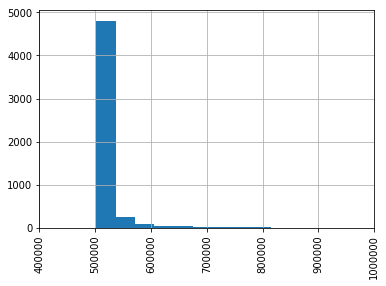

In [6]:
(df['END'] - df['START'] + 1).hist(bins=1000, xrot=90)
plt.xlim((400000, 1000000))

### _Q1a:_ What is the minimum, median and maximum bin size? [4 points]

In [7]:
# TODO: insert code to print the min, median and max bin size
print("min:",pd.Series.min(df['END'] - df['START'] + 1))
print("median:",pd.Series.median(df['END'] - df['START'] + 1))
print("max:",pd.Series.max(df['END'] - df['START'] + 1))

min: 501688
median: 514870.0
max: 35387248


_Answer:_ 
* min: 501688
* median: 514870.0
* max: 35387248

We retain bins with lengths between 450,000 and 500,000 using the following command.

In [8]:
df = df[(450000 <= (df['END'] - df['START'] + 1)) & ((df['END'] - df['START'] + 1) <= 550000)]

### _Q1b:_ The column `CHR` contains the chromosome label. Do these cells originate from a male or female patient? [4 points]

In [9]:
# TODO: write code here to print unique list of values in 'CHR' column

print("female")

female


_Answer:_ female

Next, we remove the sex chromosomes such that each bin in a normal cell has copy number 2.
### _Q1c:_ How many bins occur on autosomal chromosomes? [4 points]

In [10]:
# TODO: insert code to generate a list of chromosome labels corresponding to autosomes, e.g. ['chr1', 'chr2', ...]
autosomes = list(set(df["CHR"]))
autosomes.remove("chrX")
autosomes.remove("chrY")




In [11]:
len(df[df['CHR'].isin(autosomes)])

4718

_Answer:_ 4718 bins

In [12]:
4718# we retain only autosomes
df = df[df['CHR'].isin(autosomes)]


Due to variablity in library preparation, there are differences in the total number of reads per cell. We construct a new dataframe with the total number of reads, and plot a histogram as follows.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CD9E456048>]],
      dtype=object)

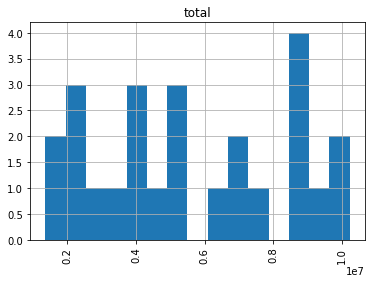

In [13]:
df_total_reads = pd.DataFrame.from_records([(cell, int(df[cell].sum())) for cell in cells], columns=['cell', 'total'])
df_total_reads.hist(column="total", bins=15, xrot=90)

### _Q1d:_ Based on the above plot, we decide to exclude the six cells with a total read count of less than 30,000,000 reads. Which six cells are excluded? [4 points]

In [14]:
cells_to_keep = list(df_total_reads[df_total_reads['total'] >= 3000000]['cell'])


In [15]:
# TODO: insert code to filter down to cells with less 300,000 reads
df_removed_cells = list(df_total_reads[df_total_reads['total'] < 3000000]['cell'])

In [16]:
df_removed_cells
for idx,(cellname, read) in df_total_reads.T.iteritems():
    if cellname in df_removed_cells:
        print(cellname , "with" , read , "reads")

SRR054598 with 1784898 reads
SRR054594 with 1361308 reads
SRR053676 with 2036366 reads
SRR053679 with 2021242 reads
SRR054604 with 2473778 reads
SRR053607 with 2784633 reads


_Answer:_ 
1. SRR054598  with 1784898  reads; 
2. SRR054594  with 1361308  reads; 
3. SRR053676  with 2036366  reads; 
4. SRR053679  with 2021242  reads; 
5. SRR054604  with 2473778  reads;
6. SRR053607  with 2784633 reads.

In [17]:
 # we retain only cells with >= 300,000 reads
df = df[list(df.columns)[:3] + cells_to_keep]


The key concept is that the majority of bins in a cell are diploid. Since the bins have the same length and under the assumption of uniform genome coverage, we expect the most frequent read count, or the mode, to correspond to the diploid state. We identify the mode by discretizing the read counts for each cell into 20 bins. We then divide the read count for each bin in a cell by the mode.

### _Q1e:_ Complete the below code fragment to identify the mode of each cell and to subsequently normalize the read counts. [4 points]

In [25]:
nr_bins = 20
df2 = df.copy(deep=True)

# for cell in cells_to_keep:
# #    insert code to discretize read count (e.g. first integer division by bin_size, then multiply by bin_size)
#     largest = max(df2[cell]) 
#     bin_size = df2['END'] - df2['START'] + 1
#     df2[cell] = (df2[cell]//bin_size)*bin_size

# df2



 

# df_mode = pd.DataFrame.from_records([(cell, int(df2[cell].mode())) for cell in cells_to_keep], 
#                                     columns=['cell', 'mode'])
# df_mode


,CHR,START,END,SRR089377,SRR053605,SRR089397,SRR054614,SRR089402,SRR053633,SRR053617,...,SRR054602,SRR089401,SRR053668,SRR054606,SRR054613,SRR053631,SRR054575,SRR053611,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
2,chr1,1833663,2345598,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr1,2946627,3452945,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,chr1,4112609,4622985,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,chr1,4622984,5133470,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,chr1,5133469,5640704,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,chr1,5640703,6148783,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,chr1,6148782,6661103,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,chr1,6661102,7166066,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,chr1,7166065,7681749,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# TODO: insert code to divide each read count by the mode of the corresponding cell
# for cell in cells_to_keep:
#     df[cell] = None
df

,CHR,START,END,SRR089377,SRR053605,SRR089397,SRR054614,SRR089402,SRR053633,SRR053617,...,SRR054602,SRR089401,SRR053668,SRR054606,SRR054613,SRR053631,SRR054575,SRR053611,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,
2,chr1,1833663,2345598,1767,870,1655,1621,5418,1929,1077,...,898,3505,1109,707,1372,1342,2531,936,818,1366
4,chr1,2946627,3452945,2189,883,2081,1173,4845,1790,1170,...,854,3206,963,687,1371,1562,3235,785,784,1212
6,chr1,4112609,4622985,2449,915,2098,1532,6557,2333,1302,...,1057,4034,1053,709,1394,1824,3001,1125,877,1317
7,chr1,4622984,5133470,2084,834,1970,1579,5386,1967,1109,...,942,3774,1122,799,1201,1599,2813,1085,812,1259
8,chr1,5133469,5640704,1994,937,2240,1441,5191,2199,1149,...,852,3253,1215,645,993,1643,2499,1038,892,1601
9,chr1,5640703,6148783,2316,1269,2132,1846,4105,2629,1496,...,971,3571,1041,859,1520,1630,2083,1234,908,1300
10,chr1,6148782,6661103,1597,716,1467,1132,4115,1774,895,...,723,2450,993,630,835,1551,1991,1089,697,1077
11,chr1,6661102,7166066,2174,755,1608,1361,4591,1968,887,...,898,3143,1047,645,1081,1581,2016,871,822,1433
12,chr1,7166065,7681749,2200,881,1783,1546,4788,1967,1584,...,1148,4006,960,869,1232,1890,2181,1118,1025,1720


In [20]:
# The following commented out code generates data_filtered.tsv, which is part of the zip file of this assignment. 
# If your code is correct the resulting file should be identical to the provided file.
# df.to_csv("data_filtered_normalized.tsv", sep="\t")


## Question 2: Viterbi algorithm [50 points]

In this question we use the Viterbi algorithm to compute a copy number for each bin. The set $Q$ of hidden states corresponds to integer copy numbers. We consider $Q=\{0,\ldots,10\}$. The set $\Sigma$ of emitted symbols are normalized read counts. Since this an infinite set, we use a probability distribution function for each integer copy number to define the emission probabilities. Specifically, for copy number $c \in \{0,\ldots,10\}$ we use a normal distribution with standard deviation $\sigma = 0.1$ centered around mean $\mu_c = c / 2$.

In [27]:
df_norm = pd.read_table("data_filtered_normalized.tsv", sep="\t", index_col=0)

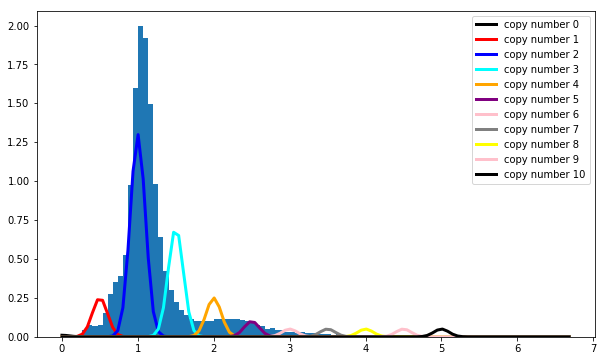

In [28]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

values = [val for sublist in [list(df_norm[cell]) for cell in list(df_norm.columns[3:])] for val in sublist]
count, bins, ignored = plt.hist(values, 100, density=True)

sigma = 0.1

plt.plot(np.array([0,.05,.1,.15,.2]),gauss(np.array([0,.05,.1,.15,.2]), 0, sigma, .01),color='black',lw=3,label='copy number 0')
plt.plot(bins,gauss(bins, 0.5, sigma, .25),color='red',lw=3,label='copy number 1')
plt.plot(bins,gauss(bins, 1, sigma, 1.3),color='blue',lw=3,label='copy number 2')
plt.plot(bins,gauss(bins, 1.5, sigma, .7),color='cyan',lw=3,label='copy number 3')
plt.plot(bins,gauss(bins, 2, sigma, .25),color='orange',lw=3,label='copy number 4')
plt.plot(bins,gauss(bins, 2.5, sigma, .1),color='purple',lw=3,label='copy number 5')
plt.plot(bins,gauss(bins, 3, sigma, .05),color='pink',lw=3,label='copy number 6')
plt.plot(bins,gauss(bins, 3.5, sigma, .05),color='gray',lw=3,label='copy number 7')
plt.plot(bins,gauss(bins, 4, sigma, .05),color='yellow',lw=3,label='copy number 8')
plt.plot(bins,gauss(bins, 4.5, sigma, .05),color='pink',lw=3,label='copy number 9')
plt.plot(bins,gauss(bins, 5, sigma, .05),color='black',lw=3,label='copy number 10')

plt.legend()
plt.gcf().set_size_inches(10, 6)

In [30]:
from scipy.stats import norm
max_copy_number = 10

def emissionLogProb(copy_number, norm_count):
    sigma = 0.1
    mu = copy_number / 2.

    # Compute Pr(|X_c - norm_count| <= 0.01 | c)  
    low = norm.cdf(norm_count - 0.01, mu, sigma)
    up = norm.cdf(norm_count + 0.01, mu, sigma)
    
    # prevent probability of 0
    prob = max(up - low, 0.0001)
    
    return np.log(prob)

def transitionLogProb(current_copy_number, next_copy_number):
    stay_prob = 0.99999
    if current_copy_number == next_copy_number:
        return np.log(stay_prob)
    elif 0 <= next_copy_number <= max_copy_number:
        return np.log((1 - stay_prob) / max_copy_number)
    else:
        return np.log(0)

def initialLogProb(copy_number):
    if 0 <= copy_number <= max_copy_number:
        return np.log(1./11)
    else:
        return np.log(0)

### _Q2a:_ Compute the joint log probability of each cell having copy number 2 in all bins. [10 points]

_Hint:_ Make use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

In [35]:
for cell in list(df_norm.columns[3:]):
    log_prob = 0
    for idx, norm_count in df_norm[cell].iteritems():
        # TODO: insert code here
        # Hint: idx == 0 is the initial item.
        if idx != 0:
            log_prob += emissionLogProb(2,norm_count)+transitionLogProb(2,2)
        else:
            log_prob += emissionLogProb(2,norm_count)+initialLogProb(2)
    
    print(cell, log_prob)

SRR089377 -15219.789046840733
SRR053605 -15578.100682201888
SRR089397 -15341.89317914691
SRR054614 -28486.442059180677
SRR089402 -37689.64042528754
SRR053633 -17980.665275592724
SRR053617 -16591.83324736538
SRR054608 -28629.646253643343
SRR053608 -17018.88489979599
SRR054602 -29999.56321734497
SRR089401 -35737.275021497466
SRR053668 -23687.561122802355
SRR054606 -36758.68301171966
SRR054613 -28302.29275709495
SRR053631 -21786.499207109642
SRR054575 -34594.39115384095
SRR053611 -15430.556501784851
SRR053602 -18423.853700046162
SRR054610 -28584.287624901153


### _Q2b:_ Determine the maximum joint log probability of each cell using the Viterbi algorithm. [20 points]

_Hint:_ Complete the function `viterbi` and `max_joint_prob`, making use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

In [57]:
def viterbi(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))
        
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : -np.inf for bin in bins } for c in range(max_copy_number + 1) ]

    
    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        for state in Q:
            #initilization step
#             print(state,idx)
            if idx == 0:
                v[state][bin] = emissionLogProb(state,norm_count)+initialLogProb(state) 
            #recursion step
            else:
                #calc max
                for s in Q:
                    temp = emissionLogProb(state,norm_count)+transitionLogProb(s,state)+v[s][bins[idx-1]]
                    if temp > v[state][bin]:
                        v[state][bin] = temp
    return v

def max_joint_prob(df_norm, v):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    # TODO: insert code here
    max_prob = v[0][last_bin]
    for state in Q:
        temp = v[state][last_bin]
        if temp > max_prob:
            max_prob = temp
    return max_prob

V = {}
for cell in list(df_norm.columns[3:]):
    V[cell] = viterbi(df_norm, cell)
    print(cell, "--", "max prob:", max_joint_prob(df_norm, V[cell]))

SRR089377 -- max prob: -43456.830940491986
SRR053605 -- max prob: -43456.830940491986
SRR089397 -- max prob: -43456.830940491986
SRR054614 -- max prob: -43456.830940491986
SRR089402 -- max prob: -43436.79004538069
SRR053633 -- max prob: -43456.830940491986
SRR053617 -- max prob: -43456.830940491986
SRR054608 -- max prob: -43456.830940491986
SRR053608 -- max prob: -43456.830940491986
SRR054602 -- max prob: -43456.830940491986
SRR089401 -- max prob: -43456.830940491986
SRR053668 -- max prob: -43456.830940491986
SRR054606 -- max prob: -43456.830940491986
SRR054613 -- max prob: -43456.830940491986
SRR053631 -- max prob: -43456.830940491986
SRR054575 -- max prob: -43456.830940491986
SRR053611 -- max prob: -43456.830940491986
SRR053602 -- max prob: -43456.830940491986
SRR054610 -- max prob: -43456.830940491986


### _Q2c:_ Compute the most likely copy number profile for each cell. [10 points]

_Hint:_ Hint perform a backtrace or extend the above `viterbi` function to maintain backpointers.

In [ ]:
def viterbi_bt(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : -np.inf for bin in bins } for c in range(max_copy_number + 1) ]
    bt = [ { bin : None for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        for state in Q:
            #initilization step
#             print(state,idx)
            if idx == 0:
                v[state][bin] = emissionLogProb(state,norm_count)+initialLogProb(state) 
                bt[state][bin] = 0
            #recursion step
            else:
                #calc max
                for s in Q:
                    temp = emissionLogProb(state,norm_count)+transitionLogProb(s,state)+v[s][bins[idx-1]]
                    if temp > v[state][bin]:
                        v[state][bin] = temp
                        bt[state][bin] = s
    return v, bt

bins = sorted(list(df_norm.index))
Q = range(max_copy_number+1)

V = {}
BT = {}
C = {}
for cell in list(df_norm.columns[3:]):

    V[cell], BT[cell] = viterbi_bt(df_norm, cell)
    C[cell] = {}

    max_prob = max_joint_prob(df_norm, V[cell])
    final_c = None
    final_bin = bins[-1]
    for c in Q:
        if V[cell][c][final_bin] == max_prob:
            final_c = c

    C[cell][final_bin] = final_c

    for idx in range(len(bins)-2, -1, -1):
        bin = bins[idx]
        next_bin = bins[idx + 1]
        next_bin_c = C[cell][next_bin]
        C[cell][bin] = BT[cell][next_bin_c][next_bin]

    print(cell, "--", "max prob:", max_joint_prob(df_norm, V[cell]))

SRR089377 -- max prob: -43456.830940491986
SRR053605 -- max prob: -43456.830940491986
SRR089397 -- max prob: -43456.830940491986
SRR054614 -- max prob: -43456.830940491986
SRR089402 -- max prob: -43436.79004538069
SRR053633 -- max prob: -43456.830940491986
SRR053617 -- max prob: -43456.830940491986
SRR054608 -- max prob: -43456.830940491986
SRR053608 -- max prob: -43456.830940491986
SRR054602 -- max prob: -43456.830940491986
SRR089401 -- max prob: -43456.830940491986
SRR053668 -- max prob: -43456.830940491986
SRR054606 -- max prob: -43456.830940491986
SRR054613 -- max prob: -43456.830940491986
SRR053631 -- max prob: -43456.830940491986
SRR054575 -- max prob: -43456.830940491986
SRR053611 -- max prob: -43456.830940491986


### _Q2d:_ Which cells are normal cells (i.e. have copy number 2 for each bin)? [10 points]

_Hint:_ Use `visualizeCopyNumbers(C, bins)`.

_Answer:_ XXX

In [67]:
bins = sorted(list(df_norm.index))

In [68]:
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(range(len(bins)), C[cell].values())
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("bin")
        ax.set_ylabel("copy number")
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")

{'SRR053605': {2: 10,
  4: 10,
  6: 10,
  7: 10,
  8: 10,
  9: 10,
  10: 10,
  11: 10,
  12: 10,
  13: 10,
  14: 10,
  15: 10,
  16: 10,
  17: 10,
  18: 10,
  19: 10,
  20: 10,
  21: 10,
  22: 10,
  24: 10,
  25: 10,
  26: 10,
  27: 10,
  28: 10,
  30: 10,
  31: 10,
  32: 10,
  33: 10,
  34: 10,
  35: 10,
  36: 10,
  37: 10,
  38: 10,
  39: 10,
  40: 10,
  41: 10,
  42: 10,
  43: 10,
  44: 10,
  45: 10,
  47: 10,
  48: 10,
  49: 10,
  50: 10,
  51: 10,
  52: 10,
  53: 10,
  55: 10,
  56: 10,
  57: 10,
  58: 10,
  59: 10,
  60: 10,
  61: 10,
  62: 10,
  63: 10,
  64: 10,
  65: 10,
  66: 10,
  67: 10,
  68: 10,
  69: 10,
  70: 10,
  71: 10,
  72: 10,
  73: 10,
  74: 10,
  75: 10,
  76: 10,
  77: 10,
  78: 10,
  79: 10,
  80: 10,
  81: 10,
  82: 10,
  83: 10,
  84: 10,
  85: 10,
  86: 10,
  87: 10,
  89: 10,
  90: 10,
  91: 10,
  92: 10,
  93: 10,
  94: 10,
  95: 10,
  96: 10,
  97: 10,
  98: 10,
  99: 10,
  100: 10,
  101: 10,
  102: 10,
  103: 10,
  104: 10,
  105: 10,
  106: 10,
  107:

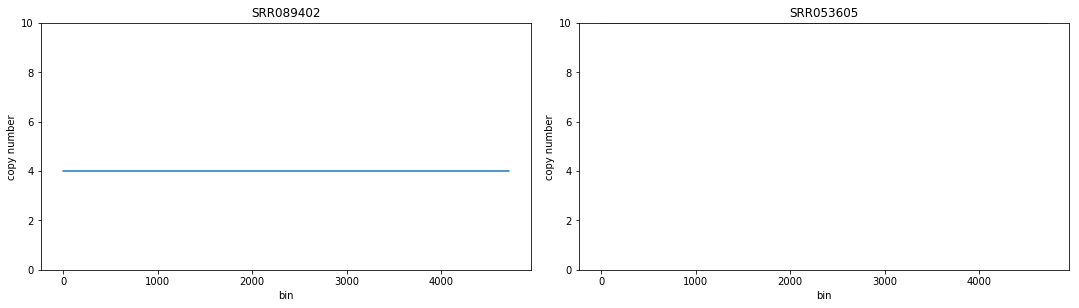

In [69]:
visualizeCopyNumbers(C, bins)

### _Q2e -- Bonus:_ Extend the plotting function to delineate chromosomes using vertical lines. Do not forget to update x-axis labels to show chromosomes. [5 points]

## Question 3: Forward algorithm [10 points]

### _Q3a:_ Compute the marginal log probability of the observations using the forward algorithm. [10 points]
_Hint:_ Be aware that recurrence of the forward algorithm includes a summation, but we are operating in log space.

In [ ]:
def forward(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization f[copy_number][bin] = 0
    f = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df.loc[bin][cell])
        
        # TODO: insert code here
        pass

    return f

def marginal_log_prob(df_norm, f):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    # insert code here
    return None

F = {}
for cell in list(df_norm.columns[3:]):
    F[cell] = forward(df_norm, cell)
    print(cell, "--", "marginal log prob:", marginal_log_prob(df_norm, F[cell]))

## Question 4: Hierarchical clustering [20 points]
The Python package `scipy` implements hierarchical clustering. We will use this method to perform single linkage cluster with the Manhattan (also known as cityblock) distance metric.

In [1]:
C_values = [C[cell].values() for cell in C]
C_labels = C.keys()

NameError: name 'C' is not defined

In [ ]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(C_values, 'single', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)

The goal of this question is to reimplement this algorithm. We start by computing the initial distance matrix.

### _Q4a:_ Compute the initial distance matrix using Manhattan distance. [10 points]

In [ ]:
def manhattan(C, cell_1, cell_2, bins):
    # TODO: insert code here
    return None

bins = sorted(list(df_norm.index))
dist = {}
for cell_1 in C.keys():
    dist[cell_1] = {}
    for cell_2 in C.keys():
        dist[cell_1][cell_2] = manhattan(C, cell_1, cell_2, bins)

### _Q4b:_ Implement single linkage clustering. [10 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

In [ ]:
import copy
def cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = distances.keys()
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: insert code to identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = None, None, None

        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = n + len(Z)
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]), 
                      axis=0)
        
        # TODO: insert code to update distances
        distances[new_cluster] = {}


        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)

        clusters.remove(c1)
        clusters.remove(c2)
        
    return Z

In [ ]:
Z = cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)

### _Q4c -- Bonus:_ Implement complete linkage clustering. [5 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage. Your plot should be identical to the below scipy plot.

In [ ]:
from scipy.cluster import hierarchy
Z = hierarchy.linkage(C_values, 'complete', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)